In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t1, solve_t2, make_population, plot_t1, plot_t2
from qutip import basis, tensor
from qtt.algorithms.functions import gauss_ramsey, fit_gauss_ramsey, plot_gauss_ramsey_fit

from qutip import basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, mesolve, identity, Qobj, destroy, qeye
from tqdm import tqdm


In [2]:
def sz_analytic(tlist, g):
    return np.cos(2 * np.pi * tlist) * np.exp(-tlist * g)

In [3]:
# Define system parameters
SYSTEM_PARAMS = {
    "fq1": 3.2,  # GHz, Qubit 1 frequency
    "fq2": 3.35,  # GHz, Qubit 2 frequency
    "fTLS": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "JTLS": 0.05,  # GHz, Coupling strength between Qubit 1 and TLS
    "relaxation": {"q1": 1/200, "q2": 1/250, "TLS": 1/500},  # Relaxation rates
    "dephasing": {"q1": 1/150, "q2": 1/180, "TLS": 1/300},  # Dephasing rates
    "Jzz": 0.00, # Jzz coupling
    "Jxx": 0.00, # Jxx coupling
    "Jxt": 0.00, # Jxt coupling
    "time_points": np.linspace(0, 300, 100)  # Time points in μs
}

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

# get times
tlist = SYSTEM_PARAMS["time_points"]

# T1 measurement for Qubit 1 

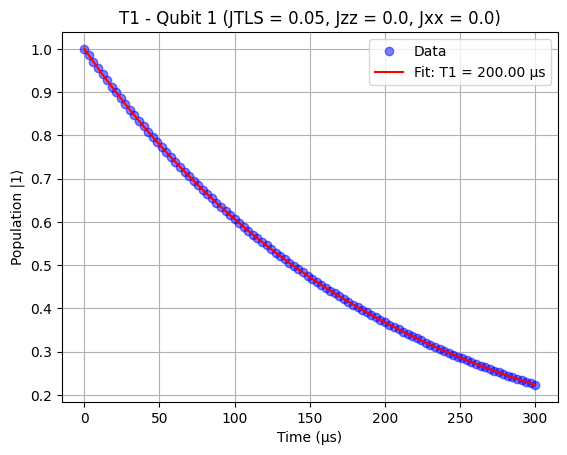

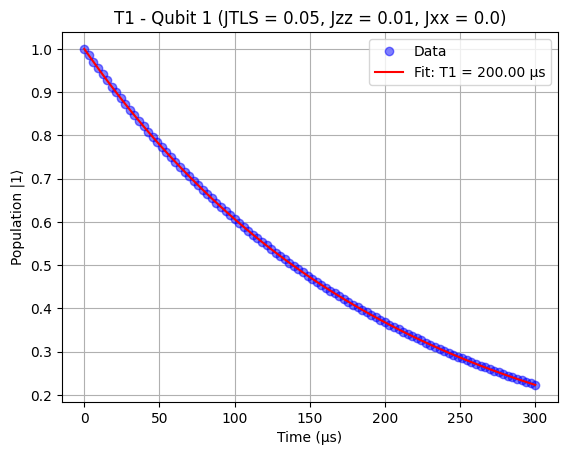

In [4]:
# T1 measurement for Qubit 1 
psi0 = tensor(basis(2,0), basis(2,1), basis(2,1))  # |0⟩|1⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q1], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q1], "Qubit 1", SYSTEM_PARAMS)


# with coupling
SYSTEM_PARAMS["Jzz"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,0), basis(2,1), basis(2,1))  # |0⟩|1⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q1], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q1], "Qubit 1", SYSTEM_PARAMS)
plt.show() 


# T1 measurement for Qubit 2 

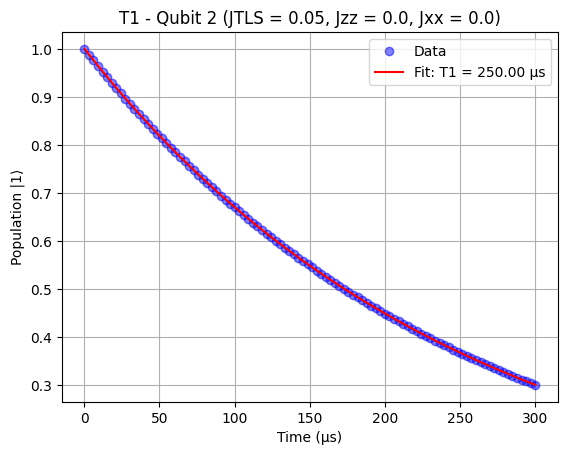

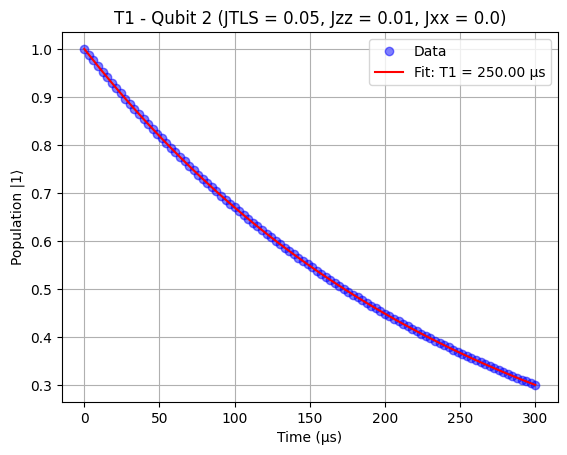

In [5]:
# T1 measurement for Qubit 2 
SYSTEM_PARAMS["Jzz"] = 0.00
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), basis(2,0), basis(2,1))  # |1⟩|0⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q2], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q2], "Qubit 2", SYSTEM_PARAMS)

SYSTEM_PARAMS["Jzz"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)
psi0 = tensor(basis(2,1), basis(2,0), basis(2,1))  # |1⟩|0⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q2], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q2], "Qubit 2", SYSTEM_PARAMS)

plt.show()

# T2 measurement for Qubit 1 

In [5]:
# T2 measurement for Qubit 1 
SYSTEM_PARAMS["Jzz"] = 0.0  #0.0
SYSTEM_PARAMS["JTLS"] = 0.05 #0.05
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor((basis(2,1) + basis(2,0)).unit(), basis(2,1), basis(2,1))  # |+⟩|1⟩|1⟩


first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q1"], SYSTEM_PARAMS["fq1"], 0.0, 0.5]
#first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q1"], 3.1, 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, "Qubit 1", SYSTEM_PARAMS,  use_fit_gauss=False)
#plt.plot(tlist, make_population(sz_analytic(tlist, 1.0/180)), label="Analytic")

# with coupling
SYSTEM_PARAMS["Jzz"] = 0.02
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)
psi0 = tensor((basis(2,1) + basis(2,0)).unit(), basis(2,1), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q1"], SYSTEM_PARAMS["fq1"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, "Qubit 1", SYSTEM_PARAMS)
#plt.plot(tlist, make_population(sz_analytic(tlist, 1.0/180)), label="Analytic")

plt.show()

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

# T2 measurement for Qubit 2 

In [ ]:
# T2 measurement for Qubit 2 
SYSTEM_PARAMS["Jzz"] = 0.00
SYSTEM_PARAMS["Jxx"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)

# with coupling
SYSTEM_PARAMS["Jzz"] = 0.01
SYSTEM_PARAMS["Jxx"] = 0.00
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)
plt.show()

In [ ]:
# 

In [ ]:
# T2 measurement for Qubit 2 
SYSTEM_PARAMS["Jzz"] = 0.00
SYSTEM_PARAMS["Jxx"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)

# with coupling
SYSTEM_PARAMS["Jzz"] = 0.01
SYSTEM_PARAMS["Jxx"] = 0.00
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)
plt.show()

# Scanning Jzz

# Scan Q1

In [ ]:

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.80, 10)
JTLS_vals = np.linspace(0.00, 0.80, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor( (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1),  basis(2, 1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q1"], params["fq1"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
  
        if fit_par[1] > 85:
            plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)
            fit_par[1] = 60

        if do_print:
            plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)
            do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('Q1 T2* as a function of Jzz and JTLS')
plt.show()

#print(T2_matrix)

# Scan Q2

In [ ]:

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.99, 10)
JTLS_vals = np.linspace(0.00, 0.99, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(  basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |1⟩|+⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
  
        if fit_par[1] < 20:
            plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
            fit_par[1] = 75

        if do_print:
            plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
            do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('Q2 T2* as a function of Jzz and JTLS')
plt.show()

#print(T2_matrix)

In [ ]:
1-(74.4/75.4)

In [ ]:
###########################################

In [ ]:

# Define parameter ranges
Jzz_vals = np.linspace(0.01, 0.02, 21)
JTLS_vals = np.linspace(0.01, 0.10, 21)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]

counter = 0
tot =  len(Jzz_vals) * len(JTLS_vals)

for i, Jzz in enumerate(Jzz_vals):
    for j, JTLS in enumerate(JTLS_vals):
        if counter % 10 == 0 :
            print(f'loop: {counter}/{tot}')
        counter+=1

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(  basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(),  basis(2, 1))  # |1⟩|+⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('Q1 T2* as a function of Jzz and JTLS')
plt.show()

#print(T2_matrix)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t2
from qutip import basis, tensor

# Define parameter ranges
Jzz_vals = np.linspace(0.01, 0.05, 21)
Jxx_vals = np.linspace(0.01, 0.15, 21)
T2_matrix = np.zeros((len(Jzz_vals), len(Jxx_vals)))

# Base system parameters (without Jzz and Jxx)
base_params = {
    "fq1": 3.2,
    "fq2": 3.35,
    "fTLS": 3.2,
    "relaxation": {"q1": 1/20, "q2": 1/25, "TLS": 1/5},
    "dephasing": {"q1": 1/15, "q2": 1/18, "TLS": 1/3},
    "JTLS": 0.05,
    "time_points": np.linspace(0, 100, 200)
}

tlist = base_params["time_points"]

for i, Jzz in enumerate(Jzz_vals):
    for j, Jxx in enumerate(Jxx_vals):
        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["Jxx"] = Jxx

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
        except Exception as e:
            print(f"Error solving T2 for Jzz={Jzz}, Jxx={Jxx}: {e}")
            continue
        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[Jxx_vals[0], Jxx_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('Jxx')
plt.ylabel('Jzz')
plt.title('T2* as a function of Jzz and Jxx')
plt.show()

In [ ]:
# single qbit
sz_q1 = sigmaz()

H = 2 * np.pi * 3.2 / 2 * sz_q1

c_ops = [
    np.sqrt(1/20) * sigmam(),
    np.sqrt((1/18)) * sigmaz(),
]

tlist = np.linspace(0, 300, 100)

# T2 measurement for Qubit 1 
psi0 = (basis(2, 0) + basis(2, 1)).unit()  # |+⟩|1⟩|1⟩


first_guess = [0.5, 1.0 / (1/18), # best guess
                  3.2, 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sigmax()], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sigmax()], first_guess, "Qubit 2", SYSTEM_PARAMS)
plt.show()

